# Goal

Company XYZ started a subscription model in January, 2015. You get hired as a first data scientist at the end of August and, as a first task, you are asked to help executives understand how the subscription model is doing.
Therefore, you decide to pull data from all the users who subscribed in January and see, for each month, how many of them unsubscribed. In particular, your boss is interested in:

1. A model that predicts monthly retention rate for the different subscription price points

2. Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

3. How do user country and source affect subscription retention rate? 

4. How would you use these findings to improve the company revenue?


# Data

Columns:

user_id : the id of the user. Unique by user.

subscription_signup_date : when the user signed up for the subscription. It is always Jan, 2015 in this table.

subscription_monthly_cost : how much the user pays each month for the subscription (USD)

source : marketing acquisition channel (SEO/Ads/Friend Referral)

billing_cycles : total billing cycles as of the end of August.

is_active : whether the subscription is still active (1) or not (0). If billing cycles is 8, it means the user has still an active subscription.


In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import date, timedelta


import pdpbox
from pdpbox import pdp
from pdpbox.info_plots import target_plot
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.tree.export import export_text
from sklearn.tree import plot_tree
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("subscription.csv")

In [3]:
df.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


In [4]:
df.describe()

,user_id,subscription_monthly_cost,billing_cycles,is_active
count,500000.000000,500000.000000,500000.000000,500000.000000
mean,250000.500000,48.469620,2.384970,0.099998
std,144337.711635,19.570745,2.254952,0.299998
min,1.000000,29.000000,1.000000,0.000000
25%,125000.750000,29.000000,1.000000,0.000000
50%,250000.500000,49.000000,1.000000,0.000000
75%,375000.250000,49.000000,3.000000,0.000000
max,500000.000000,99.000000,8.000000,1.000000


In [3]:
df["unsub_month"] = 1
df["unsub_month"] = df["unsub_month"] + df["billing_cycles"]

In [6]:
df.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active,unsub_month
0,1459,"January, 2015",29,Spain,ads,4,0,5
1,12474,"January, 2015",49,France,ads,5,0,6
2,12294,"January, 2015",49,Germany,ads,2,0,3
3,3878,"January, 2015",49,China,ads,1,0,2
4,9567,"January, 2015",49,UK,ads,5,0,6


In [7]:
df.shape

(500000, 8)

## Question 1
A model that predicts monthly retention rate for the different subscription price points

Important factors:
1. retention rate: Aggregate Retention vs. Cohort Retention
2. Average Customer Lifespan
3. Customer Lifetime Value

reference: https://medium.com/subscribe-commerce/approaches-to-forecasting-subscription-revenue-939207ef601b

In [4]:
df["subscription_monthly_cost"].unique()

array([29, 49, 99])

In [5]:
df_99 = df[df["subscription_monthly_cost"]==99]
df_49 = df[df["subscription_monthly_cost"]==49]
df_29 = df[df["subscription_monthly_cost"]==29]

In [6]:
print(df_99.shape)
print(df_49.shape)
print(df_29.shape)

(53241, 8)
(300397, 8)
(146362, 8)


In [10]:
df_99.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active,unsub_month
8,1026,"January, 2015",99,Spain,ads,1,0,2
12,7715,"January, 2015",99,China,seo,1,0,2
48,4718,"January, 2015",99,UK,ads,2,0,3
55,6085,"January, 2015",99,France,ads,1,0,2
72,3192,"January, 2015",99,Germany,seo,1,0,2


In [6]:
def keep_num(data,var):
    mon_total = []
    for i in range(2,10):
        mon_total.append(data[data[var]>=i].shape[0])
    ratio = pd.DataFrame(mon_total).rolling(2).apply(lambda x: x[1]/x[0])
    ratio = ratio[1:]
    ratio.columns = ["ratio"]
    ratio["month"] = list(range(2,2+ratio.shape[0]))
    return [mon_total, ratio]

In [7]:
# linear regression
from sklearn.linear_model import LinearRegression
def lm_model(data):
    x = np.array(data["month"]).reshape((-1, 1))
    y = np.array(data["ratio"])
    model = LinearRegression().fit(x, y)
    inter = model.intercept_
    coeffi = model.coef_
    return[inter,coeffi]

In [8]:
# logarithmic curve fit
# reference: https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly
def log_model(data):
    x = np.array(data["month"])
    y = np.array(data["ratio"])
    [coeffi, inter] = np.polyfit(np.log(x), y, 1)
    return [coeffi, inter]

In [97]:
# complicated curve fit
from scipy.optimize import curve_fit
def l( x, a, b):
    return 1 - 1/(a+b*np.log(x+1))
# def l2( x, a, b):
#     return a*np.tanh(b*np.sqrt(x))

In [9]:
[mon_t_29, ratio_29] = keep_num(df_29,"unsub_month")
[mon_t_49, ratio_49] = keep_num(df_49,"unsub_month")
[mon_t_99, ratio_99] = keep_num(df_99,"unsub_month")

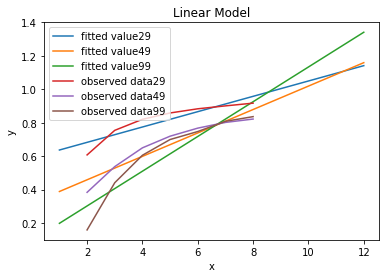

In [10]:
# obvious under-fit
[inter_29,coef_29] = lm_model(ratio_29)
[inter_49,coef_49] = lm_model(ratio_49)
[inter_99,coef_99] = lm_model(ratio_99)
x = np.linspace(1,12,100)
y_29 = inter_29+coef_29[0]*x
y_49 = inter_49+coef_49[0]*x
y_99 = inter_99+coef_99[0]*x
plt.plot(x, y_29, label = "fitted value29")
plt.plot(x, y_49, label = "fitted value49")
plt.plot(x, y_99, label = "fitted value99")
plt.plot(ratio_29["month"],ratio_29["ratio"], label = "observed data29")
plt.plot(ratio_49["month"],ratio_49["ratio"], label = "observed data49")
plt.plot(ratio_99["month"],ratio_99["ratio"], label = "observed data99")
plt.title("Linear Model")
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

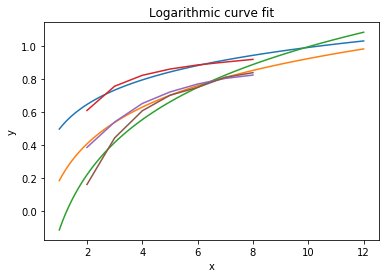

In [14]:
# better than lm, but still have two problems
# underfit
# the maximum would exceed 1

[l_coef_29, l_inter_29] = log_model(ratio_29)
[l_coef_49, l_inter_49] = log_model(ratio_49)
[l_coef_99, l_inter_99] = log_model(ratio_99)
l_y_29 = l_coef_29*np.log(x)+l_inter_29
l_y_49 = l_coef_49*np.log(x)+l_inter_49
l_y_99 = l_coef_99*np.log(x)+l_inter_99
plt.plot(x, l_y_29, label = "fitted data29")
plt.plot(x, l_y_49, label = "fitted data49")
plt.plot(x, l_y_99, label = "fitted data99")
plt.plot(ratio_29["month"],ratio_29["ratio"], label = "observed data29")
plt.plot(ratio_49["month"],ratio_49["ratio"], label = "observed data49")
plt.plot(ratio_99["month"],ratio_99["ratio"], label = "observed data99")
plt.title("Logarithmic curve fit")
#plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

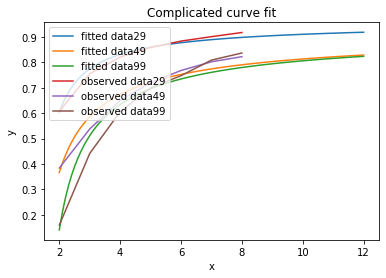

In [118]:
# best
# underfit for price point = 49 or 99
x = np.linspace(2,12,100)
[param_29,cov_29] = curve_fit(l, ratio_29["month"], ratio_29["ratio"])
[param_49,cov_49] = curve_fit(l, ratio_49["month"], ratio_49["ratio"])
[param_99,cov_99] = curve_fit(l, ratio_99["month"], ratio_99["ratio"])
l_y_29 = 1 - 1/(param_29[0]+param_29[1]*np.log(x+1))
l_y_49 = 1 - 1/(param_49[0]+param_49[1]*np.log(x+1))
l_y_99 = 1 - 1/(param_99[0]+param_99[1]*np.log(x+1))
plt.plot(x, l_y_29, label = "fitted data29")
plt.plot(x, l_y_49, label = "fitted data49")
plt.plot(x, l_y_99, label = "fitted data99")
plt.plot(ratio_29["month"],ratio_29["ratio"], label = "observed data29")
plt.plot(ratio_49["month"],ratio_49["ratio"], label = "observed data49")
plt.plot(ratio_99["month"],ratio_99["ratio"], label = "observed data99")
plt.title("Complicated curve fit")
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [119]:
y_pred_29 = 1 - 1/(param_29[0] + param_29[1] * np.log(ratio_29["month"] + 1))
y_pred_49 = 1 - 1/(param_49[0] + param_49[1] * np.log(ratio_49["month"] + 1))
y_pred_99 = 1 - 1/(param_99[0] + param_99[1] * np.log(ratio_99["month"] + 1))
acc_29 = np.sqrt(sum((y_pred_29 - ratio_29["ratio"])**2)/7)
acc_49 = np.sqrt(sum((y_pred_49 - ratio_49["ratio"])**2)/7)
acc_99 = np.sqrt(sum((y_pred_99 - ratio_99["ratio"])**2)/7)
print(acc_29)
print(acc_49)
print(acc_99)

0.012282468355794602
0.027271612330309353
0.041129156403390786


In [120]:
#prediction for December
Dec = 12
Dec_pred_29 = 1 - 1/(param_29[0]+param_29[1]*np.log(Dec+1))
Dec_pred_49 = 1 - 1/(param_49[0]+param_49[1]*np.log(Dec+1))
Dec_pred_99 = 1 - 1/(param_99[0]+param_99[1]*np.log(Dec+1))
print("As for the price point = 29, the predicted monthly retention rate is", Dec_pred_29)
print("As for the price point = 49, the predicted monthly retention rate is", Dec_pred_49)
print("As for the price point = 99, the predicted monthly retention rate is", Dec_pred_99)

As for the price point = 29, the predicted monthly retention rate is 0.9183776770579325
As for the price point = 49, the predicted monthly retention rate is 0.828664900952401
As for the price point = 99, the predicted monthly retention rate is 0.8235042273780062


In [ ]:
# life span
df_list = [df_99,df_49,df_29]

lifespan = []
for dataframe in df_list:
    lifespan.append(round(dataframe["billing_cycles"].mean(),2))
lifespan = pd.DataFrame(lifespan)
lifespan.columns = ["lifespan"]
lifespan["price"] = [99,49,29]
lifespan

In [ ]:
# life value
price_list = [99,49,29]

lifevalue = []

for [dataframe,price] in zip(df_list,price_list):
    lifevalue.append(round(dataframe["billing_cycles"].mean()*price,2))
lifevalue = pd.DataFrame(lifevalue)
lifevalue.columns = ["lifevalue"]
lifevalue["price"] = [99,49,29]
lifevalue

#### cohort retention

pdp plot for different prices each month to find the segmentation which has best monthly retention rate.
Decision tree to find a combination of segment and compare with the result of pdp.

#### cluster the life span&life value and predict

#### problem

Hasn't found a function can have a restricted range of 0,1
